In [1]:
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import os

import numpy as np
import os
import networkx as nx
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, f1_score

from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from node_embed import *

st_models = ["roberta-large-nli-stsb-mean-tokens", "xlm-r-large-en-ko-nli-ststb", "distilbert-base-nli-mean-tokens"]

In [2]:
import os
os.listdir()

['__pycache__',
 'GNN-Nets-Copy1.ipynb',
 '.ipynb_checkpoints',
 'GNN-Nets.ipynb',
 'node_embed.py',
 'graph_builder.py']

In [3]:
def create_graphs(dataset="pan-2017-age"):
    path = "../embeddings/"+dataset+"/"
    kg_z = []
    for split in ["train", "dev", "test"]:
        path_tmp = path + split + ".tsv"            
        curr_file = np.loadtxt((path_tmp))
        print(curr_file.shape)
        kg_z.append(curr_file)#np.loadtxt((path_tmp)))
    return np.vstack(kg_z)

In [4]:
graph = create_graphs()#.shape

(225, 768)
(76, 768)
(101, 768)


In [5]:
graph

array([[-0.03205629,  0.03208702, -0.02638447, ...,  0.00941179,
        -0.03959925, -0.02185475],
       [-0.02643134,  0.07622029, -0.02060491, ...,  0.03786241,
        -0.06958942, -0.0175699 ],
       [ 0.02041859,  0.00554185, -0.02657186, ...,  0.0222062 ,
        -0.04971696, -0.0241206 ],
       ...,
       [ 0.06723179,  0.0192865 , -0.03909617, ...,  0.03505384,
        -0.02167776, -0.03509651],
       [ 0.05465534,  0.07386344, -0.03056697, ...,  0.03233298,
        -0.01600522, -0.03404968],
       [ 0.06309358,  0.08859846, -0.03989247, ...,  0.01561929,
        -0.00608071,  0.00114027]])

In [3]:
def load_lbls(dataset,mode='train'):
    lbls = {}
    for mode in ['train','dev','test']:
        path = "representations/"+dataset+"/"+mode+"/_ys.csv"
        
        lbls[mode] = np.loadtxt((path))
    return lbls

In [4]:
import pandas as pd
def load_features(dataset, features):
    feats = {}
    for m in ["train", "dev", "test"]:
        path = 'representations/'+dataset+"/"+m+"/"+features+".csv"
        #feats[m] = np.loadtxt((path))
        if features == 'all':
            feats[m] = prepare_all('representations/'+dataset+"/"+m)
        else:
            df = pd.read_csv(path,header=None)
            feats[m] = df.to_numpy()
    return feats


In [5]:
def prep_kgs(kg_emb, split='train'):
    embs = []
    global dataset
    path_in = "kg_emb_dump/"+dataset+"/"+split+"_"+kg_emb+'_n.pkl'
    with open(path_in, "rb") as f:
        kgs_p = pickle.load(f)
    for x,y in kgs_p:
        embs.append(x)
    return embs

In [6]:
def build_adj(train_set):
    adj = np.zeros((len(train_set),len(train_set)))
    for i, x in enumerate(train_set):
        for j, y in enumerate(train_set):
            if i != j:
                #adj[i][j] = len(set(x).difference(set(y)))
                adj[i][j] = len(set(x).intersection(set(y))) if len(set(x).intersection(set(y))) > 0 else 0
    return adj

In [7]:
def merge(dics):
    mats = []
    for mode in ['train','dev','test']:
        if mode == 'train':
            mats = dics[mode]
        else:
            mats = np.vstack((mats, dics[mode]))
    return mats

In [8]:
def make_masks(data):
    train_len, dev_len, test_len = len(data['train']), len(data['dev']), len(data['test'])
    
    train_mask = [True]* train_len + [False] * dev_len + [False ]* test_len
    dev_mask =[False]* train_len + [True] * dev_len + [False ]* test_len
    test_mask = [False]* train_len + [False] * dev_len + [True ]* test_len
    return np.array(train_mask), np.array(dev_mask), np.array(test_mask)

In [9]:
def prepare(dataset='pan2020', txt_emb = 'stat'):
    feat_info = load_features(dataset, txt_emb)
    feat_info = merge(feat_info)
    
    labels = load_lbls(dataset)
    labels = labels['train'].tolist() + labels['dev'].tolist() + labels['test'].tolist()
    labels = np.array((labels))
    kg_info = export_kgs(dataset)
    train_mask, dev_mask, test_mask = make_masks(kg_info)    
    kg_info = kg_info['train'] + kg_info['dev'] + kg_info['test']
    adj = build_adj(kg_info)
    adj = np.array((adj))
    return feat_info, labels, adj, train_mask, dev_mask, test_mask

In [10]:
kg_types = ["transe"]#"complex","rotate","quate","simple","transe","distmult"]# "complex_entity", "transe_entity", "rotate_entity", "quate_entity", "distmult_entity", "simple_entity"]
LM_types = ["lsa","roberta-large-nli-stsb-mean-tokens","stat","xlm-r-large-en-ko-nli-ststb"]
def prepare_all(split):
    dataz = None
    first = True
    for lm in LM_types:
        path = split+"/"+lm+".csv"
        df = pd.read_csv(path,header=None).to_numpy()
        if first:
            dataz = df
            first = False
        else:
            dataz = np.hstack((dataz, df))
    for kg in kg_types:
        path = split+"/"+kg+".csv"
        df = pd.read_csv(path,header=None).to_numpy()
        dataz = np.hstack((dataz, df))

    return preprocessing.scale(dataz)


In [230]:
def prep_lbls(lbls):
    new_lbls = []
    for x in lbls:
        xs = [0,0]
        xs[int(x)] = 1
        new_lbls.append(xs)
    return np.array(new_lbls)

In [238]:
def meta_adj(adjs, strat):
    if strat == 'scale':
        return preprocessing.scale(adjs)
    if strat == 'median':
        op = np.median(adjs)
    if strat == 'mean':
        op = np.mean(adjs)
    for i in range(adjs.shape[0]):
        for j in range(adjs.shape[1]):
            if adjs[i][j] < op:
                adjs[i][j] = 0
    return adjs


In [10]:
def fits(A, channels = 32,dropout = 0.7, learning_rate = 1e-2):
    # Preprocessing operations
    A = GraphConv.preprocess(A).astype('f4')

    # Model definition
    X_in = Input(shape=(F, ))
    fltr_in = Input((N, ), sparse=True)

    dropout_1 = Dropout(dropout)(X_in)
    graph_conv_1 = GCNConv(channels,activation='relu',kernel_regularizer=l2(l2_reg),use_bias=False)([dropout_1, fltr_in])
 
    #dropout_3 = Dropout(dropout)(graph_conv_1)
    #graph_conv_3 = GraphConv(channels//2,activation='relu',kernel_regularizer=l2(l2_reg),use_bias=False)([dropout_1, fltr_in])

    dropout_2 = Dropout(dropout)(graph_conv_1)
    graph_conv_2 = GraphConv(num_classes, activation='softmax', use_bias=False)([dropout_2, fltr_in])

    # Build model
    model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  weighted_metrics=['acc'])
    #model.summary()

    tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
        log_dir='./Tensorboard_GCN_cora',
    )
    callback_GCN = [tbCallBack_GCN]
    return model

In [233]:
def train(model):
    # Train model
    validation_data = ([X, adj], new_l, dev_mask)
    train_history  = model.fit([X, adj],
              new_l,
              sample_weight=train_mask,
              epochs=epochs,
              batch_size=N,
              validation_data=validation_data,
              shuffle=False,
              callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_GCN
              ],
              verbose=0)
    loss = train_history.history['loss']
    return model, min(loss)

In [234]:
namez = []
for channel in channels:
    for strategy in strategies:
        for dropout in dropouts:
            namez.append("_".join([str(channel),str(strategy),str(dropout)]))  

In [235]:
namez[np.argmin(losses)]

'2_scale_0.7'

In [261]:
dataset = 'pan2020'#'AAAI2021_COVID19_fake_news'
X, labels, adj, train_mask, dev_mask, test_mask = prepare(dataset, txt_emb = 'lsa')

In [262]:
strategies = ['mean','median','scale']
adj2strat = {}
for strategy in strategies:        
    adj2strat[strategy] = meta_adj(adj, strategy)

In [279]:
channels = [4,16,32,64,128,256,512,1024,2048,4096]
dropouts = [0.1,0.2,0.5,0.7,0.8,0.9]
losses = []
F = X.shape[1]
N = X.shape[0]
num_classes = len(set(labels))
new_l = prep_lbls(labels)
best_model = None
best_loss = 12131
for channel in channels:
    for strategy in strategies:
        for dropout in dropouts:
            n_adj = adj2strat[strategy]
            #G = nx.from_numpy_matrix(n_adj) 
            #A = nx.adjacency_matrix(G)
            model = fits(A,channel)
            model, loss = train(model)
            if loss < best_loss:
                best_model = model
                best_loss = loss
            print(channel, strategy, loss)
            losses.append(loss)

/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:00:03 - Method (on_train_batch_end) is slow compared to the batch update (0.156012). Check your callbacks.


4 mean 0.37730053067207336


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 mean 1.064375638961792


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:01:33 - Method (on_train_batch_end) is slow compared to the batch update (0.100749). Check your callbacks.


4 mean 0.5077710747718811


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 mean 0.37185972929000854


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 mean 33036.75


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 mean 4419.212890625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 median 66178.390625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 median 24323.826171875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 median 0.4082096815109253


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 median 9362.3408203125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 median 0.36864298582077026


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 median 0.5129560232162476


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 scale 0.36948251724243164


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 scale 0.364801824092865


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 scale 7553.31103515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 scale 20295.55078125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 scale 151152.546875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4 scale 9685.94140625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 mean 9747.08203125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 mean 61360.6640625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 mean 4879.376953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 mean 33311.65625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 mean 27249.876953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 mean 51658.046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 median 45201.45703125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 median 38897.5


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 median 37451.0546875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 median 15294.0234375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 median 96805.8515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 median 39213.59765625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 scale 9462.3779296875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:10:58 - Method (on_train_batch_end) is slow compared to the batch update (0.215179). Check your callbacks.


16 scale 14153.7109375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


16 scale 29752.728515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:11:16 - Method (on_train_batch_end) is slow compared to the batch update (0.165815). Check your callbacks.


16 scale 38556.17578125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:11:29 - Method (on_train_batch_end) is slow compared to the batch update (0.134088). Check your callbacks.


16 scale 4236.19873046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:11:51 - Method (on_train_batch_end) is slow compared to the batch update (0.146210). Check your callbacks.


16 scale 19477.181640625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:12:04 - Method (on_train_batch_end) is slow compared to the batch update (0.138053). Check your callbacks.


32 mean 22521.70703125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 mean 75308.6015625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 mean 33788.453125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:12:41 - Method (on_train_batch_end) is slow compared to the batch update (0.116313). Check your callbacks.


32 mean 26324.91796875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:12:52 - Method (on_train_batch_end) is slow compared to the batch update (0.108394). Check your callbacks.


32 mean 16713.8046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:13:06 - Method (on_train_batch_end) is slow compared to the batch update (0.100554). Check your callbacks.


32 mean 13013.833984375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 median 63944.21875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 median 124672.609375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 median 48698.48828125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 median 19392.30078125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 median 25040.34765625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:14:09 - Method (on_train_batch_end) is slow compared to the batch update (0.101721). Check your callbacks.


32 median 40674.8046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 scale 29041.59765625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 scale 82131.515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 scale 51250.2265625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 scale 57878.30078125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 scale 25813.865234375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


32 scale 25662.26953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 mean 46467.03125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 mean 14141.6123046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 mean 62241.48046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 mean 28432.6875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 mean 34510.6328125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 mean 14875.23046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 median 20096.5703125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 median 45865.87890625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 median 36354.23046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 median 91388.34375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 median 27141.53125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 median 47242.78125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 scale 27848.697265625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 scale 36610.7109375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 scale 45344.859375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 scale 66480.296875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 scale 33347.88671875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


64 scale 36008.84375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 mean 27157.412109375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 mean 36144.515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 mean 61130.8046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 mean 35051.4296875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 mean 88586.0390625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 mean 59731.74609375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 median 33887.26953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 median 16615.001953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 median 40620.61328125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 median 22577.248046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 median 21849.193359375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 median 50029.484375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 scale 57461.7890625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 scale 22767.509765625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 scale 24772.974609375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 scale 59556.3515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 scale 62595.7890625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


128 scale 106241.8984375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


256 mean 31348.654296875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:22:36 - Method (on_train_batch_end) is slow compared to the batch update (0.138943). Check your callbacks.


256 mean 15270.08984375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:22:51 - Method (on_train_batch_end) is slow compared to the batch update (0.148680). Check your callbacks.


256 mean 56725.91015625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:23:03 - Method (on_train_batch_end) is slow compared to the batch update (0.154131). Check your callbacks.


256 mean 66065.5625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


256 mean 71672.34375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:23:22 - Method (on_train_batch_end) is slow compared to the batch update (0.144734). Check your callbacks.


256 mean 19845.857421875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:23:42 - Method (on_train_batch_end) is slow compared to the batch update (0.142339). Check your callbacks.


256 median 24740.623046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:23:57 - Method (on_train_batch_end) is slow compared to the batch update (0.128516). Check your callbacks.


256 median 20156.751953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


256 median 50098.53125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:24:28 - Method (on_train_batch_end) is slow compared to the batch update (0.118582). Check your callbacks.


256 median 96682.2734375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:24:38 - Method (on_train_batch_end) is slow compared to the batch update (0.132939). Check your callbacks.


256 median 35681.37109375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:24:51 - Method (on_train_batch_end) is slow compared to the batch update (0.114072). Check your callbacks.


256 median 40246.1796875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:25:04 - Method (on_train_batch_end) is slow compared to the batch update (0.110857). Check your callbacks.


256 scale 15269.052734375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


256 scale 17128.294921875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


256 scale 67479.171875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


256 scale 20111.5625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:25:50 - Method (on_train_batch_end) is slow compared to the batch update (0.105742). Check your callbacks.


256 scale 32904.62109375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:26:04 - Method (on_train_batch_end) is slow compared to the batch update (0.107287). Check your callbacks.


256 scale 25681.720703125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:26:18 - Method (on_train_batch_end) is slow compared to the batch update (0.102175). Check your callbacks.


512 mean 45183.06640625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 mean 69878.8046875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 mean 3383.11083984375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 mean 27177.833984375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 mean 138418.21875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 mean 21267.876953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 median 12762.568359375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 median 6900.26806640625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 median 45973.44921875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 median 53571.25390625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 median 28293.771484375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:28:39 - Method (on_train_batch_end) is slow compared to the batch update (0.110736). Check your callbacks.


512 median 26183.134765625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 scale 81667.90625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 scale 27946.236328125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 scale 27215.064453125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 scale 34740.078125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 scale 15582.19921875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


512 scale 61291.82421875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 mean 39752.94921875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 mean 138046.6875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 mean 28333.1015625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 mean 16761.576171875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 mean 34879.53125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 mean 103178.171875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 median 21391.7734375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 median 9648.251953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 median 25848.607421875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 median 10764.1943359375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 median 9924.12109375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 median 18375.01953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 scale 220.0729217529297


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 scale 49421.78125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 scale 1915.8614501953125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 scale 81616.4140625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 scale 17351.703125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


1024 scale 2640.825927734375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


2048 mean 174.30433654785156


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


2048 mean 25797.228515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


2048 mean 8112.7724609375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:34:56 - Method (on_train_batch_end) is slow compared to the batch update (0.232531). Check your callbacks.


2048 mean 321.05023193359375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:35:16 - Method (on_train_batch_end) is slow compared to the batch update (0.148620). Check your callbacks.


2048 mean 6694.14208984375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


2048 mean 2320.643310546875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:35:38 - Method (on_train_batch_end) is slow compared to the batch update (0.131990). Check your callbacks.


2048 median 468.1722717285156


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:36:02 - Method (on_train_batch_end) is slow compared to the batch update (0.121138). Check your callbacks.


2048 median 452.16046142578125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:36:21 - Method (on_train_batch_end) is slow compared to the batch update (0.140579). Check your callbacks.


2048 median 117.58782196044922


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:36:38 - Method (on_train_batch_end) is slow compared to the batch update (0.132225). Check your callbacks.


2048 median 3237.754150390625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:36:54 - Method (on_train_batch_end) is slow compared to the batch update (0.123883). Check your callbacks.


2048 median 29820.345703125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:37:09 - Method (on_train_batch_end) is slow compared to the batch update (0.130616). Check your callbacks.


2048 median 51970.2578125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:37:24 - Method (on_train_batch_end) is slow compared to the batch update (0.119035). Check your callbacks.


2048 scale 14942.111328125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:37:40 - Method (on_train_batch_end) is slow compared to the batch update (0.118723). Check your callbacks.


2048 scale 2463.394287109375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


2048 scale 1552.36865234375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:38:02 - Method (on_train_batch_end) is slow compared to the batch update (0.113542). Check your callbacks.


2048 scale 6420.80908203125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:38:21 - Method (on_train_batch_end) is slow compared to the batch update (0.101586). Check your callbacks.


2048 scale 131.57945251464844


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


2048 scale 1104.787109375


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:39:00 - Method (on_train_batch_end) is slow compared to the batch update (0.105404). Check your callbacks.


4096 mean 114340.7578125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:39:14 - Method (on_train_batch_end) is slow compared to the batch update (0.101438). Check your callbacks.


4096 mean 2522.192138671875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 mean 20843.826171875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 mean 2507.177978515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:40:00 - Method (on_train_batch_end) is slow compared to the batch update (0.101218). Check your callbacks.


4096 mean 1733.81103515625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 mean 211.83795166015625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 median 291.6106262207031


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()
12-May-21 15:40:43 - Method (on_train_batch_end) is slow compared to the batch update (0.104632). Check your callbacks.


4096 median 246.09141540527344


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 median 2050.703857421875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 median 638.033935546875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 median 7258.3076171875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 median 44.6147575378418


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 scale 3118.6142578125


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 scale 471.20904541015625


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 scale 706.9871215820312


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 scale 139.99436950683594


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 scale 323.30487060546875


/home/boshkok/miniconda3/lib/python3.7/site-packages/spektral/utils/convolution.py:30: RuntimeWarning: invalid value encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


4096 scale 16896.6875


In [280]:
model = best_model

In [281]:
np.argmin(losses)

13

In [282]:
with open(dataset+".pkl","wb") as f:
    pickle.dump(losses,f)

In [283]:
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 500
Number of edges: 125214
Average degree: 500.8560


In [284]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = new_l[test_mask]

y_pred = best_model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1))
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

           0       0.49      0.93      0.64       100
           1       0.36      0.04      0.07       100

    accuracy                           0.48       200
   macro avg       0.43      0.49      0.36       200
weighted avg       0.43      0.48      0.36       200



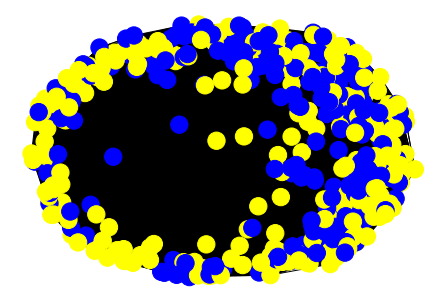

In [285]:
import matplotlib.pyplot as plt
node_lbls = ['blue' if e == 1 else 'yellow' for e in labels]

nx.draw(G, node_color = node_lbls)
plt.show()


In [286]:
def f1(recall, prec):
    return 2/(1/recall + 1/prec)
